In [1]:
import os
import pandas as pd
import dask.dataframe as dd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [2]:
mainpath = 'C:/Users/david/OneDrive/Documents/FERV_documentos/RESULTS'
dic_cenarios = {
                # 'MPA FNS Lim Scenario 2022' : f'{mainpath}/MPV_(FNS Lim)_RC/',
                # 'V1A1F2 Scenario 2026' :f'{mainpath}/V1A1F2_RESP_FNS_lim_rev1_2026/',
                # 'V1A1F3 Scenario 2026' :f'{mainpath}/V1A1F3_RESP_FNS_lim_rev1_2026/',
                # 'V1A1F4 Scenario 2026' :f'{mainpath}/V1A1F4_RESP_FNS_lim_rev1_2026/',
                # 'V1A1F5 Scenario 2026' :f'{mainpath}/V1A1F5_RESP_FNS_lim_rev1_2026/',
                # 'V1A1F2 Scenario 2026 rev2' :f'{mainpath}/V1A1F2_RESP_FNS_lim_rev2_2026/',
                'V2A2F2 Scenario 2026' :f'{mainpath}/V2A2F2_REV02_2026/',
                'V2A2F3 Scenario 2026' :f'{mainpath}/V2A2F3_REV02_2026/',
                'V2A2F4 Scenario 2026' :f'{mainpath}/V2A2F4_REV02_2026/',
                'V2A2F5 Scenario 2026' :f'{mainpath}/V2A2F5_REV02_2026/',
                # 'V3A3F2 Scenario 2026 rev0' :f'{mainpath}/V3A3F2_REV0_2026/',
                # 'V3A3F3 Scenario 2026 rev0' :f'{mainpath}/V3A3F3_REV0_2026/',
                # 'V3A3F4 Scenario 2026 rev0' :f'{mainpath}/V3A3F4_REV0_2026/',
                # 'V3A3F5 Scenario 2026 rev0' :f'{mainpath}/V3A3F5_REV0_2026/',
                # 'V3A3F2 Scenario 2026 rev1' :f'{mainpath}/V3A3F2_REV1_2026/',
                # 'V3A3F3 Scenario 2026 rev1' :f'{mainpath}/V3A3F3_REV1_2026/',
                # 'V3A3F4 Scenario 2026 rev1' :f'{mainpath}/V3A3F4_REV1_2026/',
                # 'V3A3F5 Scenario 2026 rev1' :f'{mainpath}/V3A3F5_REV1_2026/',
                }

dirGeral = 'StaticAnalysis/Data/Geral/'
# dirIndice = 'StaticAnalysis/Data/Indice_n_supremo/'
dirIndice = 'StaticAnalysis/Data/Indice_n_2/'
dirRamos = 'StaticAnalysis/Data/Fluxo em Ramos/'
dirPotencia = 'StaticAnalysis/Data/Potencia/'

filenames = [
                (dirGeral + 'OPF_NC.csv', 'OPF_NC'), 
                (dirGeral + 'PWF_NC.csv', 'PWF_NC'),
                (dirGeral + 'Df_ger.csv', 'ger'), 
                (dirGeral + 'Df_nt.csv', 'nt'), 
                (dirRamos + 'Df_Linhas.csv', 'linhas'), 
                (dirRamos + 'Df_Trafo.csv', 'Trafo'), 
                (dirRamos + 'DF_Intercambios.csv', 'intercambios'), 
                (dirRamos + 'DF_HVDC.csv', 'HVDC'), 
                (dirIndice + 'Df_DPI_S2.csv', 'Index'), 
                (dirIndice +'Df_DPI_S4.csv', 'Index_PO'), 
                (dirIndice + 'Df_DPI_S3.csv', 'Index_Modif'), 
                (dirIndice +'Df_PQ_DPI_S1.csv', 'IndexDec_PQ'), 
                (dirIndice +'Df_PV_DPI_S1.csv', 'IndexDec_PV'), 
                # (dirPotencia+'Df_MW-MVAR_PO.csv', 'pot_mw_mvar'),  
                (dirPotencia+'Df_Reserva_PO_MW.csv', 'pot_mw_reserv'), 
                (dirPotencia+'Df_Reserva_PO_MVAR.csv', 'pot_mvar_reserv'),
                (dirPotencia+'DF_POT_Reg.csv', 'ger_reg'),
            ]

intense_palette = sns.color_palette("bright", 10)  # You can adjust the number of colors as needed
namescenarios = {key:[key,intense_palette[idx]] for idx, key in enumerate(dic_cenarios.keys())}

# Data Processing

In [3]:
def read_data():
    def read_and_append(filename, cenario, lst):
        df = dd.read_csv(filename)
        df['Cenario'] = cenario
        # if cenario == 'V1A1F2 Scenario 2022 FNS':
        #     df['Dia'] = df['Dia'] - 1
        lst.append(df.compute())
        return lst

    keys = [i for _,i in filenames]
    dfs = {}
    for key in keys:
        dfs[key] = []
    for i,j in  dic_cenarios.items():
        for filename, key in filenames:
            dfs[key] = read_and_append(j + filename, i, dfs[key])

    return dfs

In [4]:
# Function to calculate indices for lines
def IndiceLinhas(df, n):
    df_filtered = df.loc[
        ~(df['L1(MVA)'] == 9999) & df['VBASEKV'].isin([230, 345, 440, 500, 525, 765])
    ].copy()
    df_filtered['MW_Flow'] = np.where(
        df_filtered['MW:From-To'] >= 0, df_filtered['MW:From-To'], df_filtered['MW:To-From']
    )
    df_filtered['PI_mva'] = (df_filtered['% L1'] / 100) ** (2 * n)

    # Group by multiple columns and aggregate
    df_r_nt = df_filtered.groupby(
        ['Dia', 'Hora', 'Cenario', 'REG', 'VBASEKV']
    ).agg({'MW_Flow': 'sum', 'MVA': 'sum', 'PI_mva': 'sum'})
    df_r = df_filtered.groupby(
        ['Dia', 'Hora', 'Cenario', 'REG']
    ).agg({'MW_Flow': 'sum', 'MVA': 'sum', 'PI_mva': 'sum'})
    df_po = df_filtered.groupby(
        ['Dia', 'Hora', 'Cenario']
    ).agg({'MW_Flow': 'sum', 'MVA': 'sum', 'PI_mva': 'sum'})

    # Calculate PFI
    for df in [df_r_nt, df_r, df_po]:
        df['PFI'] = df['MW_Flow'] / df['MVA']
        df['PI_mva'] = df['PI_mva'] ** (1 / (2 * n))

    return df_r_nt, df_r, df_po

# Function to flatten DataFrame
def flatdf(df, BG):
    df_reordered = df.reorder_levels(['Dia', 'Hora', 'Cenario', 'REG', BG])
    regionmap = {
        'Nordeste': 'Northeast', 'Norte': 'North', 'Sudeste-Centro-Oeste': 'SE-CW',
        'Sul': 'South', 'AC-RO': 'AC-RO'
    }
    df_reordered = df_reordered.rename(index=regionmap, level='REG')
    df_reordered_sorted = df_reordered.sort_index(level=['Dia', 'Hora', 'Cenario', 'REG'])
    df_reordered_sorted.rename(columns={'CSI_INF': 'DPI_inf', 'CSI_SUP': 'DPI_sup'}, inplace=True)

    lista = [[index[0], index[1], index[2]] for index in df_reordered.index]
    conjunto_filtros = set(map(tuple, lista))
    conjunto_filtros = tuple(sorted(conjunto_filtros))

    data = [df_reordered_sorted.loc[i].values.flatten() for i in conjunto_filtros]
    datapd = pd.DataFrame(data, index=conjunto_filtros)
    datapd.index.names = ['Dia', 'Hora', 'Cenario']
    
    columns = []
    for reg in df_reordered_sorted.reset_index('REG')['REG'].unique():
        for bg in df_reordered_sorted.loc[:, :, :, reg, :].reset_index(BG)[BG].unique():
            for column in df_reordered_sorted.columns:
                reg_name = 'SE-CO' if reg == 'Sudeste-Centro-Oeste' else reg
                columns.append(f"{column}_{reg_name}_{bg}")

    datapd.columns = columns
    return datapd

# Function to read data
def read_data():
    def read_and_append(filename, cenario, lst):
        df = dd.read_csv(filename)
        df['Cenario'] = cenario
        # if cenario == 'V1A1F2 Scenario 2022 FNS':
        #     df['Dia'] = df['Dia'] - 1
        lst.append(df.compute())
        return lst

    keys = [i for _,i in filenames]
    dfs = {}
    for key in keys:
        dfs[key] = []
    for i,j in  dic_cenarios.items():
        for filename, key in filenames:
            dfs[key] = read_and_append(j + filename, i, dfs[key])

    return dfs

# Funtion to obtain the main features (buses) that contribute in the DPI_1 
def computefeatures(df_nt, df_ger, dfpq, dfpv):
    # Step 1: Merge DataFrames
    datafeatures_pq = df_nt.merge(
        dfpq[['CSI_INF', 'CSI_SUP']],
        on=['Dia', 'Hora', 'Cenario', 'REG', 'VBASEKV'], how='left'
    )[['BUS_ID', 'BUS_NAME', 'ARE', 'VBASEKV', 'REG', 'U_FED', 'Dia', 'Hora', 'CSI_INF', 'CSI_SUP', 'IndiceInf', 'IndiceSup', 'B0_MVAR']]

    datafeatures_pv = df_ger.merge(
        dfpv[['CSI_INF', 'CSI_SUP']],
        on=['Dia', 'Hora', 'Cenario', 'REG', 'Gen_Type'], how='left'
    )[['BUS_ID', 'BUS_NAME', 'ARE', 'Gen_Type', 'REG', 'U_FED', 'Dia', 'Hora', 'CSI_INF', 'CSI_SUP', 'IndiceInf', 'IndiceSup', 'PG_MW']]

    # Step 2: Calculate Importance
    for df in [datafeatures_pq, datafeatures_pv]:
        df['Importance_inf'] = df.apply(lambda row: row['IndiceInf'] / row['CSI_INF'] if row['CSI_INF'] != 0 else 0, axis=1)
        df['Importance_sup'] = df.apply(lambda row: row['IndiceSup'] / row['CSI_SUP'] if row['CSI_SUP'] != 0 else 0, axis=1)

    # Step 3: Filter rows
    datafeatures_pq = datafeatures_pq[datafeatures_pq['B0_MVAR'].notna() & (datafeatures_pq['B0_MVAR'] != 0)]
    datafeatures_pv = datafeatures_pv[datafeatures_pv['PG_MW'].notna() & (datafeatures_pv['PG_MW'] != 0)]

    # Step 4: Group by BUS_ID and aggregate fields
    dfeatures_pq = datafeatures_pq.groupby('BUS_ID').agg({
        'Importance_inf': 'mean',
        'Importance_sup': 'mean',
        'REG': 'first',
        'VBASEKV': 'first',
        'BUS_NAME': 'first'
    }).reset_index()

    dfeatures_pv = datafeatures_pv.groupby('BUS_ID').agg({
        'Importance_inf': 'mean',
        'Importance_sup': 'mean',
        'REG': 'first',
        'Gen_Type': 'first',
        'BUS_NAME': 'first'
    }).reset_index()

    # Step 5: Extract top `nbuses` rows for Importance_inf and Importance_sup
    nbuses = 5
    result_inf_pq = (
        dfeatures_pq.groupby(['REG', 'VBASEKV'])
        .apply(lambda x: x.nlargest(nbuses, 'Importance_inf'))
        .reset_index(drop=True)
    )[['REG', 'VBASEKV', 'BUS_ID','BUS_NAME', 'Importance_inf']]

    result_sup_pq = (
        dfeatures_pq.groupby(['REG', 'VBASEKV'])
        .apply(lambda x: x.nlargest(nbuses, 'Importance_sup'))
        .reset_index(drop=True)
    )[['REG', 'VBASEKV', 'BUS_ID','BUS_NAME', 'Importance_sup']]

    result_inf_pv = (
        dfeatures_pv.groupby(['REG', 'Gen_Type'])
        .apply(lambda x: x.nlargest(nbuses, 'Importance_inf'))
        .reset_index(drop=True)
    )[['REG', 'Gen_Type', 'BUS_ID','BUS_NAME', 'Importance_inf']]

    result_sup_pv = (
        dfeatures_pv.groupby(['REG', 'Gen_Type'])
        .apply(lambda x: x.nlargest(nbuses, 'Importance_sup'))
        .reset_index(drop=True)
    )[['REG', 'Gen_Type', 'BUS_ID','BUS_NAME', 'Importance_sup']]


    # Step 6: Filter by BUS_ID
    features_inf_pq = result_inf_pq[(result_inf_pq['Importance_inf'] != 0)]
    features_sup_pq = result_sup_pq[(result_sup_pq['Importance_sup'] != 0)]
    features_inf_pv = result_inf_pv[(result_inf_pv['Importance_inf'] != 0)]
    features_sup_pv = result_sup_pv[(result_sup_pv['Importance_sup'] != 0)]
    
    # Step 7: Pivot tables
    def pivot_table(df, values_list, value_column, index_columns=['Dia', 'Hora', 'Cenario'], pivot_column='BUS_NAME'):
        filtered_df = df[df['BUS_ID'].isin(values_list)]
        pivot_df = filtered_df.pivot_table(index=index_columns, columns=pivot_column, values=value_column, aggfunc='first').reset_index()
        return pivot_df

    features_sup_pq_df = pivot_table(df_nt, features_sup_pq['BUS_ID'].to_list(), 'B0_MVAR')
    features_inf_pq_df = pivot_table(df_nt, features_inf_pq['BUS_ID'].to_list(), 'B0_MVAR')
    features_sup_pv_df = pivot_table(df_ger, features_sup_pv['BUS_ID'].to_list(), 'PG_MW')
    features_inf_pv_df = pivot_table(df_ger, features_inf_pv['BUS_ID'].to_list(), 'PG_MW')

    return features_sup_pq_df, features_inf_pq_df, features_sup_pv_df, features_inf_pv_df

# Function to filter data based on non-convergent conditions
def filtarNC(df_list):
    df_filtrado = []
    for df_ in df_list:
        cenario = df_['Cenario'][0]
        bool_PWF_NConv = df_indice_grop[
            df_indice_grop['Cenario'] == cenario
        ][['Dia', 'Hora']].apply(tuple, axis=1)
        filtro = df_[['Dia', 'Hora']].apply(tuple, axis=1).isin(bool_PWF_NConv)
        df_filtrado.append(df_[filtro])
    return df_filtrado

# Function to concatenate and process data (part 1)
def concatenation_1():
    data = {}
    print('====== Start concatenation ======')
    ddffpv = pd.concat(dfs['IndexDec_PV'], axis=0).set_index(['Dia', 'Hora', 'Cenario', 'REG', 'Gen_Type'])
    ddffpq = pd.concat(dfs['IndexDec_PQ'], axis=0).set_index(['Dia', 'Hora', 'Cenario', 'REG', 'VBASEKV'])

    Df_ger = pd.concat(dfs['ger'], axis=0)
    Df_nt = pd.concat(dfs['nt'], axis=0)
    
    print('====== Selecting Critical Buses as features ======')
    data['features_sup_pq_df'], data['features_inf_pq_df'], data['features_sup_pv_df'], data['features_inf_pv_df'] = computefeatures(Df_nt, Df_ger, ddffpq, ddffpv)

    data['df_DPI'] = pd.concat([flatdf(ddffpq, 'VBASEKV'), flatdf(ddffpv, 'Gen_Type')], axis=1)
    data['df_ger_reg_concat'] = pd.concat(filtarNC(dfs['ger_reg']), axis=0)
    data['df_indice_group'] = pd.concat(dfs['Index_Modif'], axis=0).rename(columns={'Unnamed: 0': 'Indice'})
    data['df_linhas'] = pd.concat(dfs['linhas'], axis=0)

    df_intercambios_01 = pd.concat(dfs['intercambios'], axis=0).rename(columns={'Intercambio AC': 'Intercambio'})
    df_hvdc_01 = pd.concat(dfs['HVDC'], axis=0).rename(columns={'Nome Elo':'Intercambio', ' P(MW)': 'MW:From-To', ' Q(Mvar)': 'Mvar:From-To'})
    df_Indice_REG = pd.concat(dfs['Index'], axis=0).rename(columns={'Unnamed: 0': 'Indice'})
    data['df_Trafo'] = pd.concat(dfs['Trafo'], axis=0).rename(columns={'% L1': '% L1_Trafo', 'Mvar:Losses': 'Mvar:Losses_Trafo'})
    data['df_reserva'] = pd.concat(dfs['pot_mw_reserv'], axis=0).set_index(['Dia', 'Hora', 'Cenario'])

    df_intercambios_01 = df_intercambios_01.set_index(['Dia', 'Hora', 'Cenario', 'Intercambio'])
    df_hvdc_01 = df_hvdc_01.set_index(['Dia', 'Hora', 'Cenario', 'Intercambio'])
    data['df_indice_grop'] = df_indice_grop.set_index(['Dia', 'Hora', 'Cenario'])
    data['df_indice_group'] = data['df_indice_group'].set_index(['Dia', 'Hora', 'Cenario'])
    data['df_Indice_REG'] = df_Indice_REG.set_index(['Indice', 'Dia', 'Hora', 'REG', 'Cenario'])

    concatenated_HVDC = pd.concat([
        df_hvdc_01.loc[:, :, :, 'Elo_FOZ-IBIUNA']['MW:From-To'],
        df_hvdc_01.loc[:, :, :, 'Elo_PVEL-ARARQ']['MW:From-To'],
        df_hvdc_01.loc[:, :, :, 'Elo_XINGU-SE']['MW:From-To'],
        df_hvdc_01.loc[:, :, :, 'Elo_CPVBTB-PVEL']['MW:From-To']
    ], axis=1, keys=['Elo_FOZ-IBIUNA', 'Elo_PVEL-ARARQ', 'Elo_XINGU-SE', 'Elo_CPVBTB-PVEL'])

    concatenated_FluxoAC = pd.concat([
        df_intercambios_01.loc[:, :, :, 'Fluxo_N-S']['MW:From-To'],
        df_intercambios_01.loc[:, :, :, 'Fluxo_NE-N']['MW:From-To'],
        df_intercambios_01.loc[:, :, :, 'Fluxo_NE-SE']['MW:From-To'],
        df_intercambios_01.loc[:, :, :, 'Fluxo_SUL-SECO']['MW:From-To']
    ], axis=1, keys=['Fluxo_N-S', 'Fluxo_NE-N', 'Fluxo_NE-SE', 'Fluxo_SUL-SECO'])

    data['df_Inter_AC_DC'] = concatenated_HVDC.merge(concatenated_FluxoAC, on=['Dia', 'Hora', 'Cenario'], how='left')
    return data

# Function to concatenate and process data (part 2)
def concatenation_2(data):
    print('====== Start processing (PO) ======')
    Df_ger = pd.concat(dfs['ger'], axis=0)

    Jirau = [7051, 7061]
    S_Antonio = [7050, 7062, 7064]
    Tucurui = [6419, 6420, 6422, 6424, 6425]
    B_Monte = [6729]
    Itaipu_50 = [1100]
    Itaipu_60 = [1107]
    I_Solt = [501]

    DFF_POT = data['df_ger_reg_concat'].drop(columns=['REG', 'PG_FERV']).groupby(by=['Dia', 'Hora', 'Cenario']).sum()
    df_linhas_500up = data['df_linhas'][data['df_linhas']['VBASEKV'].isin([500, 525, 765])]
    df_linhas_500down = data['df_linhas'][data['df_linhas']['VBASEKV'].isin([230, 345, 440])]
    df_linhas_filtered = data['df_linhas'][data['df_linhas']['VBASEKV'].isin([230, 345, 440, 500, 525, 765])]

    df_linhas_grouped = df_linhas_filtered.groupby(['Dia', 'Hora', 'Cenario']).agg({'% L1': 'mean', 'Mvar:Losses': 'sum'})
    df_linhas_grouped_500up = df_linhas_500up.groupby(['Dia', 'Hora', 'Cenario']).agg({'% L1': 'mean', 'Mvar:Losses': 'sum'})
    df_linhas_grouped_500down = df_linhas_500down.groupby(['Dia', 'Hora', 'Cenario']).agg({'% L1': 'mean', 'Mvar:Losses': 'sum'})
    
    df_linhas_grouped_500up = df_linhas_grouped_500up.rename(columns={'% L1': '% L1_500up', 'Mvar:Losses': 'Mvar:Losses_500up'})
    df_linhas_grouped_500down = df_linhas_grouped_500down.rename(columns={'% L1': '% L1_500down', 'Mvar:Losses': 'Mvar:Losses_500down'})

    DF_complete_PO = pd.concat([df_linhas_grouped_500up, df_linhas_grouped_500down, df_linhas_grouped], axis=1)
    DF_complete_PO = DF_complete_PO.merge(DFF_POT.groupby(['Dia', 'Hora', 'Cenario']).sum(), on=['Dia', 'Hora', 'Cenario'], how='left')
    DF_complete_PO = data['df_indice_group'].merge(DF_complete_PO, on=['Dia', 'Hora', 'Cenario'], how='left')

    DF_complete_PO[['Mvar:Losses_500up', '% L1_500up']] = DF_complete_PO[['Mvar:Losses_500up', '% L1_500up']].fillna(0)
    DF_complete_PO['PG_FERV'] = (DF_complete_PO['PG_EOL'] + DF_complete_PO['PG_SOL']) / DF_complete_PO['PL_MW']
    DF_complete_PO['DL_MW'] = DF_complete_PO['PL_MW'] - (DF_complete_PO['PG_EOL'] + DF_complete_PO['PG_SOL'])

    Df_ger = Df_ger[Df_ger['BUS_ID'].isin(Jirau + S_Antonio + Tucurui + B_Monte + Itaipu_50 + Itaipu_60 + I_Solt)]
    DF_complete_PO[['Jirau_MW', 'Jirau_MVAR']] = Df_ger[Df_ger['BUS_ID'].isin(Jirau)].groupby(by=['Dia', 'Hora', 'Cenario'])[['PG_MW', 'QG_MVAR']].sum()
    DF_complete_PO[['S_Antonio_MW', 'S_Antonio_MVAR']] = Df_ger[Df_ger['BUS_ID'].isin(S_Antonio)].groupby(by=['Dia', 'Hora', 'Cenario'])[['PG_MW', 'QG_MVAR']].sum()
    DF_complete_PO[['Tucurui_MW', 'Tucurui_MVAR']] = Df_ger[Df_ger['BUS_ID'].isin(Tucurui)].groupby(by=['Dia', 'Hora', 'Cenario'])[['PG_MW', 'QG_MVAR']].sum()
    DF_complete_PO[['B_Monte_MW', 'B_Monte_MVAR']] = Df_ger[Df_ger['BUS_ID'].isin(B_Monte)].groupby(by=['Dia', 'Hora', 'Cenario'])[['PG_MW', 'QG_MVAR']].sum()
    DF_complete_PO[['Itaipu_50_MW', 'Itaipu_50_MVAR']] = Df_ger[Df_ger['BUS_ID'].isin(Itaipu_50)].groupby(by=['Dia', 'Hora', 'Cenario'])[['PG_MW', 'QG_MVAR']].sum()
    DF_complete_PO[['Itaipu_60_MW', 'Itaipu_60_MVAR']] = Df_ger[Df_ger['BUS_ID'].isin(Itaipu_60)].groupby(by=['Dia', 'Hora', 'Cenario'])[['PG_MW', 'QG_MVAR']].sum()
    DF_complete_PO[['I_Solt_MW', 'I_Solt_MVAR']] = Df_ger[Df_ger['BUS_ID'].isin(I_Solt)].groupby(by=['Dia', 'Hora', 'Cenario'])[['PG_MW', 'QG_MVAR']].sum()

    return DF_complete_PO

# Function to concatenate and process data (part 3)
def concatenation_3(data):
    print('====== Start processing (REG) ======')
    DFF_POT_REG = data['df_ger_reg_concat'].set_index(['Dia', 'Hora', 'REG', 'Cenario']).drop(columns='PG_FERV')
    
    df_linhas_500up = data['df_linhas'][data['df_linhas']['VBASEKV'].isin([500, 525, 765])]
    df_linhas_500down = data['df_linhas'][data['df_linhas']['VBASEKV'].isin([230, 345, 440])]

    df_linhas_500up_grouped = df_linhas_500up.groupby(['Dia', 'Hora', 'REG', 'Cenario']).agg({'% L1': 'mean', 'Mvar:Losses': 'sum'}).rename(columns={'% L1': '% L1_500up', 'Mvar:Losses': 'Mvar:Losses_500up'})
    df_linhas_500down_grouped = df_linhas_500down.groupby(['Dia', 'Hora', 'REG', 'Cenario']).agg({'% L1': 'mean', 'Mvar:Losses': 'sum'}).rename(columns={'% L1': '% L1_500down', 'Mvar:Losses': 'Mvar:Losses_500down'})
    
    df_Trafo_grouped_REG = data['df_Trafo'][data['df_Trafo']['VBASEKV'].isin([230, 345, 440, 500, 525, 765])].groupby(by=['Dia', 'Hora', 'REG', 'Cenario']).agg({'% L1_Trafo': 'mean', 'Mvar:Losses_Trafo': 'sum'})
    df_linhas_grouped_REG = pd.concat([df_linhas_500up_grouped, df_linhas_500down_grouped], axis=1)
    
    DF_complete_PO_REG = df_linhas_grouped_REG.merge(DFF_POT_REG, on=['Dia', 'Hora', 'REG', 'Cenario'], how='left')

    df_Indice_REG_PV = data['df_Indice_REG'].loc['DPI_PV']
    df_Indice_REG_PQ = data['df_Indice_REG'].loc['DPI_PQ']
    
    df_REG_Cenario_PV = df_Indice_REG_PV.merge(DF_complete_PO_REG, on=['Dia', 'Hora', 'REG', 'Cenario'], how='left')
    df_REG_Cenario_PV = df_REG_Cenario_PV.merge(df_Trafo_grouped_REG, on=['Dia', 'Hora', 'REG', 'Cenario'], how='left')
    # df_REG_Cenario_PV = df_REG_Cenario_PV.merge(dfl_r[['PI_mva', 'PFI']], on=['Dia', 'Hora', 'REG', 'Cenario'], how='left')

    df_REG_Cenario_PQ = df_Indice_REG_PQ.merge(DF_complete_PO_REG, on=['Dia', 'Hora', 'REG', 'Cenario'], how='left')
    insecure_indices = df_indice_grop[df_indice_grop['DPI_PO_final'] > 1].index
    filtro = df_REG_Cenario_PV.index.to_frame()[['Dia', 'Hora', 'Cenario']].apply(tuple, axis=1).isin(insecure_indices)

    df_Indice_complete_PV_alarme = df_REG_Cenario_PV[~filtro]
    df_Indice_complete_PQ_alarme = df_REG_Cenario_PQ[~filtro]

    Df_data_completo_reg = df_Indice_complete_PQ_alarme[['OV DPI', 'UV DPI']].merge(df_Indice_complete_PV_alarme, on=['Dia', 'Hora', 'REG', 'Cenario'], how='left')
    Df_data_completo_reg.rename(columns={'OV DPI_x': 'OV DPI_PQ', 'UV DPI_x': 'UV DPI_PQ', 'OV DPI_y': 'OV DPI_PV', 'UV DPI_y': 'UV DPI_PV'}, inplace=True)
    Df_data_completo_reg.fillna({'Mvar:Losses_500up': 0, '% L1_500up': 0, 'Mvar:Losses_500down': 0, '% L1_500down': 0}, inplace=True)

    return Df_data_completo_reg

# Main code execution
if __name__ == '__main__':
    print('Reading data...')
    dfs = read_data()
    df_indice_grop = pd.concat(dfs['Index_PO'], axis=0)
    
    print('Concatenating data...')
    DATA = concatenation_1()

    # print('Calculating loading index...')
    # dfl_r_nt, dfl_r, dfl_po = IndiceLinhas(DATA['df_linhas'], 2)
    
    DF_complete_PO = concatenation_2(DATA)
    Df_data_completo_reg = concatenation_3(DATA)
    
    # Renaming regions
    regionmap = {
        'Nordeste': 'Northeast', 'Norte': 'North', 'Sudeste-Centro-Oeste': 'SE-CW',
        'Sul': 'South', 'AC-RO': 'AC-RO'
    }
    Df_data_completo_reg = Df_data_completo_reg.rename(index=regionmap, level='REG')


Reading data...
Concatenating data...
====== Start concatenation ======
====== Selecting Critical Buses as features ======
====== Start processing (PO) ======


C:\Users\David\AppData\Local\Temp\ipykernel_2868\4266383060.py:235: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  DFF_POT = data['df_ger_reg_concat'].drop(columns=['REG', 'PG_FERV']).groupby(by=['Dia', 'Hora', 'Cenario']).sum()


====== Start processing (REG) ======


In [5]:
def separaFERV_Load(df, condition, Load = False ):
    if Load == False:
        dff = df.reset_index().merge(DF_complete_PO[['PG_FERV']], on=['Dia', 'Hora', 'Cenario'], how='left')
        dff = dff[(dff['PG_FERV'] > condition[0]) & (dff['PG_FERV'] <= condition[1])].set_index(['Dia', 'Hora', 'Cenario','REG'])
    else:
        dff = df.reset_index().merge(DF_complete_PO[['PL_MW']], on=['Dia', 'Hora', 'Cenario'], how='left')
        dff = dff[(dff['PL_MW_y'] > condition[0]) & (dff['PL_MW_y'] <= condition[1])].set_index(['Dia', 'Hora', 'Cenario','REG'])   
        dff = dff.drop(columns='PL_MW_y').rename(columns={'PL_MW_x':'PL_MW'})  
    return dff

def reorder_and_filter(df, cenario, region, columns):
    df = df.reorder_levels(['Dia', 'Hora', 'Cenario', 'REG'])[columns]
    if cenario == 'all':
        if region == 'all':
            df_reordered = df
        elif region == 'PO':
            df_reordered = df
        else:
            df_reordered = df.loc[:, :, :, region]
    else:
        if region == 'all':
            df_reordered = df.loc[:, :, cenario, :]
        elif region == 'PO':
            df_reordered = df.loc[:, :, cenario]
        else:
            df_reordered = df.loc[:, :, cenario, region]
    return df_reordered

def set_column_names(datapd, df_reordered_sorted, region):
    if region == 'all':
        columns = []
        for reg in df_reordered_sorted.reset_index('REG')['REG'].unique():
            for column in df_reordered_sorted.columns:
                name = column + '_' + reg
                columns.append(str(name))
        datapd.columns = columns
    return datapd

def merge_data(datapd, df, cenario, key):
    if cenario == 'all':
        return datapd.merge(df, on=['Dia', 'Hora', 'Cenario'], how='left')
    if isinstance(cenario, list):
        return datapd.merge(df.loc[:, :, cenario], on=['Dia', 'Hora', 'Cenario'], how='left')
    return datapd.merge(df.loc[:, :, cenario], on=['Dia', 'Hora'], how='left')

def flatdataframe(df_data_completo, cenario, region, columns, ACDCflux=True, Reserva=False, IndiceGroup=False, DPI=False, InfoPO=False, PImva_reg_nt=False, PImva=False, Busfeatures = False, Vanalysis = None):
    """
    Flattens the provided dataframe based on the specified filters and parameters.

    Parameters:
    df_data_completo (pd.DataFrame): The complete dataframe to be flattened.
    cenario (str or list): The scenario to filter by.
    region (str): The region to filter by.
    columns (list): The columns to include in the flattened dataframe.
    ACDCflux (bool): Include AC/DC flux data.
    Reserva (bool): Include reserve data.
    IndiceGroup (bool): Include index group data.
    DPI (bool): Include DPI data.
    InfoPO (bool): Include PO info.
    PImva_reg_nt (bool): Include PImva region NT data.
    PImva (bool): Include PImva data.

    Returns:
    pd.DataFrame: The flattened dataframe.
    """
    df_reordered_sorted = reorder_and_filter(df_data_completo, cenario, region, columns)

    if region == 'all' and cenario == 'all':
        lista = [[index[0], index[1], index[2]] for index in df_reordered_sorted.index]
        conjunto_filtros = set(map(tuple, lista))
        conjunto_filtros = tuple(sorted(conjunto_filtros))
        data = [df_reordered_sorted.loc[i].values.flatten() for i in conjunto_filtros]
        datapd = pd.DataFrame(data, index=conjunto_filtros)
    else:
        datapd = df_reordered_sorted

    datapd = set_column_names(datapd, df_reordered_sorted, region)

    if cenario == 'all':
        datapd.index.set_names(['Dia', 'Hora', 'Cenario'], inplace=True)
    else:
        if isinstance(cenario, list):
            if region == 'all':
                datapd.index.set_names(['Dia', 'Hora', 'Cenario'], inplace=True)
            else:
                datapd.index.set_names(['Dia', 'Hora', 'Cenario', 'REG'], inplace=True)
        else:
            datapd.index.set_names(['Dia', 'Hora'], inplace=True)

    if ACDCflux:
        datapd = merge_data(datapd, DATA['df_Inter_AC_DC'], cenario, 'AC_DC')
    if Reserva:
        datapd = merge_data(datapd, DATA['df_reserva'][[' Reserve']], cenario, 'Reserva')
    if IndiceGroup:
        datapd = merge_data(datapd, DATA['df_indice_group'], cenario, 'IndiceGroup')
    if DPI:
        datapd = merge_data(datapd, DATA['df_DPI'], cenario, 'DPI')
    # if PImva:
    #     datapd = merge_data(datapd, dfl_po[['PI_mva', 'PFI']], cenario, 'PImva')
    # if PImva_reg_nt:
    #     dff = flatdf(dfl_r_nt[['PI_mva', 'PFI']], 'VBASEKV')
    #     datapd = merge_data(datapd, dff, cenario, 'PImva_reg_nt')
    if InfoPO:
        columns = ['PG_MW','PG_UHE', 'PG_UTE', 'PG_EOL', 'PG_SOL','PL_MW', 'DL_MW', 'Jirau_MW', 'Jirau_MVAR', 'S_Antonio_MW',
       'S_Antonio_MVAR', 'Tucurui_MW', 'Tucurui_MVAR', 'B_Monte_MW', 'B_Monte_MVAR', 'Itaipu_50_MW', 'Itaipu_50_MVAR', 'Itaipu_60_MW',
       'Itaipu_60_MVAR', 'I_Solt_MW', 'I_Solt_MVAR']
        datapd = merge_data(datapd, DF_complete_PO[columns], cenario, 'InfoPO')
    if Busfeatures:
        if Vanalysis == 'OV':
            df_aux = DATA['features_sup_pv_df'].merge(DATA['features_sup_pq_df'], on = ['Dia', 'Hora', 'Cenario'], how='left').set_index(['Dia', 'Hora', 'Cenario'])
            datapd = merge_data(datapd, df_aux, cenario, 'features_sup')
        elif Vanalysis == 'UV':
            df_aux = DATA['features_inf_pv_df'].merge(DATA['features_inf_pq_df'], on = ['Dia', 'Hora', 'Cenario'], how='left').set_index(['Dia', 'Hora', 'Cenario'])
            datapd = merge_data(datapd, df_aux, cenario, 'features_inf')

    datapd.columns = datapd.columns.astype(str)
    return datapd

# Explainability of the ML model

In [6]:
import xgboost as xgb
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import  StandardScaler
from sklearn_pandas import DataFrameMapper
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
import shap
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
shap.initjs()

In [7]:
RegressorML = True
shapValues = True
PipelineObject = False
XGB_Regressor = True
Trainall = True

cenario = 'all'
region = 'all'

# columns2 = []
# columns2 = ['OV DPI_PQ', 'UV DPI_PQ', 'OV DPI_PV', 'UV DPI_PV','PI_mva', 'PFI']
# columns2 = ['OV DPI_PQ', 'UV DPI_PQ', 'OV DPI_PV', 'UV DPI_PV','PL_MW','PG_MW','PG_UHE', 'PG_UTE', 'PG_EOL', 'PG_SOL']
columns2 = ['PL_MW','PG_MW','PG_UHE', 'PG_UTE', 'PG_EOL', 'PG_SOL']  #Colocar TRUE PARA ACDCflux
dfanalise = Df_data_completo_reg
datapd3 = flatdataframe(dfanalise, cenario, region, columns2, ACDCflux=True, Reserva=True, DPI=False, IndiceGroup=False, InfoPO=True, PImva_reg_nt=False, PImva=False, Busfeatures=False,Vanalysis='UV')
datapd3.shape

C:\Users\David\AppData\Local\Temp\ipykernel_2868\973139954.py:72: PerformanceWarning: indexing past lexsort depth may impact performance.
  data = [df_reordered_sorted.loc[i].values.flatten() for i in conjunto_filtros]


(5319, 60)

In [8]:
if RegressorML:
    # colmns = ['PV_lower','PV_upper', 'PQ_lower', 'PQ_upper', 'PI_mva', 'PFI']
    # colmns = ['PV_lower','PV_upper', 'PQ_lower', 'PQ_upper']
    colmns =['Elo_FOZ-IBIUNA', 'Elo_PVEL-ARARQ', 'Elo_XINGU-SE', 'Elo_CPVBTB-PVEL',
                'Fluxo_N-S', 'Fluxo_NE-N', 'Fluxo_NE-SE', 'Fluxo_SUL-SECO']
    # colmns = ['OV DPI_PQ_AC-RO', 'UV DPI_PQ_AC-RO', 'OV DPI_PV_AC-RO',
    #             'UV DPI_PV_AC-RO', 'OV DPI_PQ_Northeast', 'UV DPI_PQ_Northeast',
    #             'OV DPI_PV_Northeast', 'UV DPI_PV_Northeast', 'OV DPI_PQ_North',
    #             'UV DPI_PQ_North', 'OV DPI_PV_North', 'UV DPI_PV_North',
    #             'OV DPI_PQ_SE-CW', 'UV DPI_PQ_SE-CW', 'OV DPI_PV_SE-CW',
    #             'UV DPI_PV_SE-CW', 'OV DPI_PQ_South', 'UV DPI_PQ_South',
    #             'OV DPI_PV_South', 'UV DPI_PV_South']
    columns_to_keep = datapd3.columns[~datapd3.columns.isin(colmns)]
    X = datapd3[columns_to_keep]
    Y = datapd3[colmns]

In [9]:
if RegressorML:
    if Trainall:
        X_train, y_train = X, Y
    else:
        X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state = 42 ,shuffle=True) #revert
        
    numerical_features = [c for c in X_train.columns]
    num = [([n], [SimpleImputer(), StandardScaler()]) for n in numerical_features]
    # num = [([n], StandardScaler()) for n in numerical_features]
    mapper = DataFrameMapper(num, df_out=True)

    if XGB_Regressor:
        model = xgb.XGBRegressor(objective="reg:squarederror")
        pipeline = Pipeline([
        ('preprocess', mapper),
        ('xgb', model)
        ])
    else:
        model = LinearRegression()
        pipeline = Pipeline([
        ('preprocess', mapper),
        ('reg', model)
        ])
    print(f'Total de samples para trenamento: {X_train.shape[0]}')
    print(f'Total de features: {X_train.shape[1]}')
    print(f'Total de output data: {y_train.shape[1]}')

Total de samples para trenamento: 5319
Total de features: 52
Total de output data: 8


In [10]:
if RegressorML:
    if PipelineObject:
        print('========= PipelineObject ==========')
        pipeline.fit(X_train, y_train)
        if Trainall:
            y_pred = pipeline.predict(X_train)
            Y_true = y_train
        else:
            y_pred = pipeline.predict(X_test)
            Y_true = y_test
    else:
        model.fit(X_train, y_train)
        if Trainall:
            y_pred = model.predict(X_train)
            Y_true = y_train
        else:
            y_pred = model.predict(X_test)
            Y_true = y_test

    mse = mean_squared_error(Y_true, y_pred)
    mae = mean_absolute_error(Y_true, y_pred)
    r2 = r2_score(Y_true, y_pred)
    rmse = np.sqrt(mse)
    print('========= ANALIS GERAL ==========')
    print("Mean Squared Error (MSE):", mse)
    print("Mean Absolute Error (MAE):", mae)
    print("R-squared (R^2):", r2)
    print("Root Mean Squared Error (RMSE):", rmse)

    print(y_pred[0])

========= ANALIS GERAL ==========
Mean Squared Error (MSE): 1988.0984557969343
Mean Absolute Error (MAE): 29.974151692265526
R-squared (R^2): 0.9924165975962482
Root Mean Squared Error (RMSE): 44.58809769206278
[2513.3901    221.34529   417.70578   806.4554     36.450043 3856.244
 4691.637    2291.8784  ]


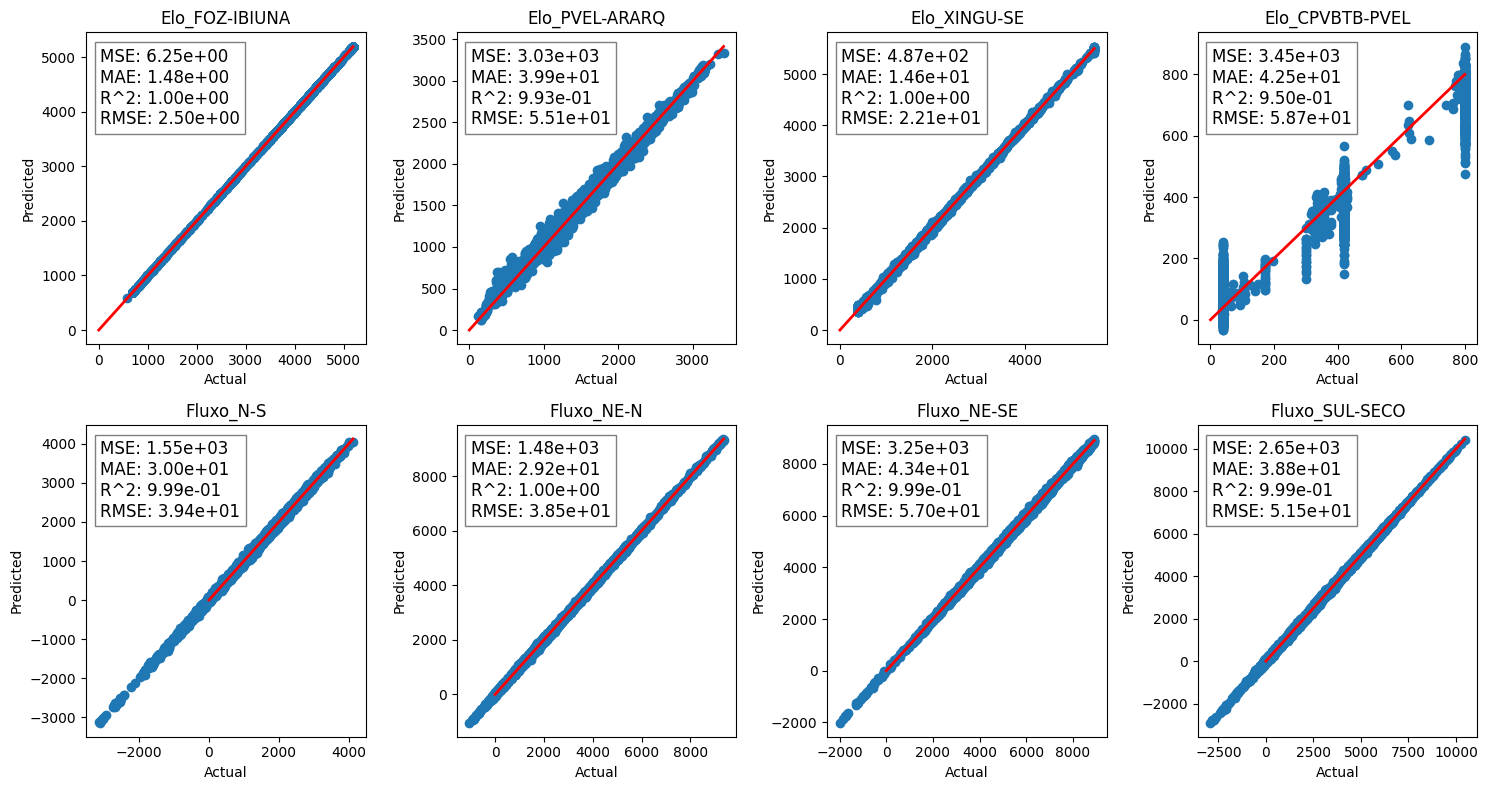

In [11]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

if RegressorML:
    num_plots = len(Y_true.columns)
    ncols = 4  # Number of columns for subplots
    nrows = (num_plots + 1) // ncols  # Number of rows for subplots

    fig, axs = plt.subplots(nrows, ncols, figsize=(15, nrows * 4))
    axs = axs.flatten()  # Flatten in case we have a 2D array of axes

    for idx, col in enumerate(Y_true.columns):
        ax = axs[idx]
        ax.scatter(Y_true.iloc[:, idx].values, y_pred[:, idx])
        ax.plot([0, Y_true.iloc[:, idx].max()], [0, Y_true.iloc[:, idx].max()], color='r', linestyle='-', linewidth=2)
        ax.set_ylabel('Predicted')
        ax.set_xlabel('Actual')
        ax.set_title(col)

        mse = mean_squared_error(Y_true.iloc[:, idx], y_pred[:, idx])
        mae = mean_absolute_error(Y_true.iloc[:, idx], y_pred[:, idx])
        r2 = r2_score(Y_true.iloc[:, idx], y_pred[:, idx])
        rmse = np.sqrt(mse)

        metrics_text = f'MSE: {mse:.2e}\nMAE: {mae:.2e}\nR^2: {r2:.2e}\nRMSE: {rmse:.2e}'
        ax.text(0.05, 0.95, metrics_text, transform=ax.transAxes, fontsize=12,
                verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))

    # Remove any unused subplots
    for j in range(idx + 1, len(axs)):
        fig.delaxes(axs[j])

    plt.tight_layout()
    plt.show()


## Shap values

In [12]:
if shapValues:
    if Trainall:
        X_test = X_train

    if PipelineObject:
        explainer = shap.Explainer(pipeline.predict, X_train, algorithm = "permutation")
        shap_values = explainer(X_test)
        shapeshap = np.shape(shap_values.values) # We have one SHAP value for each feature in our modul
        print(f'In your case, your SHAP values have shape {shapeshap}, so you have SHAP values for multiple instances ({shapeshap[0]} instances in this case) and multiple features ({shapeshap[1]} features with {shapeshap[2]} outputs).')
    else:
        if XGB_Regressor == False:
            explainer_2 = shap.Explainer(model.predict,X_train,algorithm = "permutation")
        else:
            explainer_2 = shap.Explainer(model,algorithm = "tree")
            
        shap_values_2 = explainer_2(X_test)
        shapeshap_2 = np.shape(shap_values_2.values) # We have one SHAP value for each feature in our modul
        print(f'In your case, your SHAP values have shape {shapeshap_2}, so you have SHAP values for multiple instances ({shapeshap_2[0]} instances in this case) and multiple features ({shapeshap_2[1]} features with {shapeshap_2[2]} outputs).')

In your case, your SHAP values have shape (5319, 52, 8), so you have SHAP values for multiple instances (5319 instances in this case) and multiple features (52 features with 8 outputs).


In [13]:
# if shapValues:
    # Assuming shap_values is your array with shape (1346, 143, 6)
    # Selecting SHAP values for a specific instance (e.g., first instance) and output (e.g., first output)
    # instance_index = 0
    # for i in range(shapeshap[2]):
    #     shap_values_instance_output = shap_values[instance_index][:, i]
    #     # Visualize waterfall plot for the selected instance and output
    #     plt.title(f'{Y.columns[i]}')
    #     shap.plots.waterfall(shap_values_instance_output,max_display=10)
        
    # #Mean SHAP
    # for i in range(shapeshap[2]):
    #     plt.title(f'{Y.columns[i]}')
    #     shap.plots.bar(shap_values[:,:, i],max_display=15) #Features that have made large positive/negative contributions will have a large mean SHAP value.

    # # Beeswarm plot
    # for i in range(shapeshap[2]):
    #     plt.title(f'{Y.columns[i]}')
    #     shap.plots.beeswarm(shap_values[:,:, i],max_display=15)

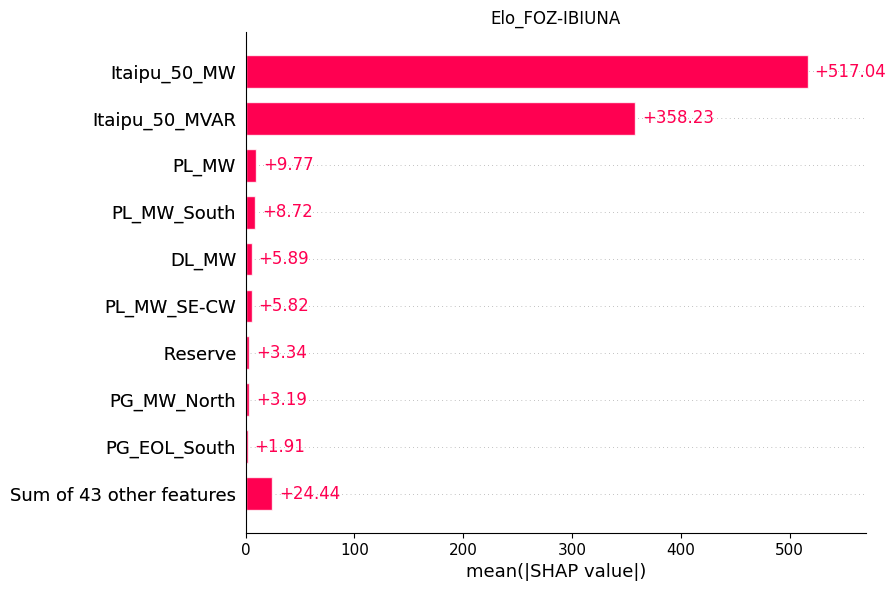

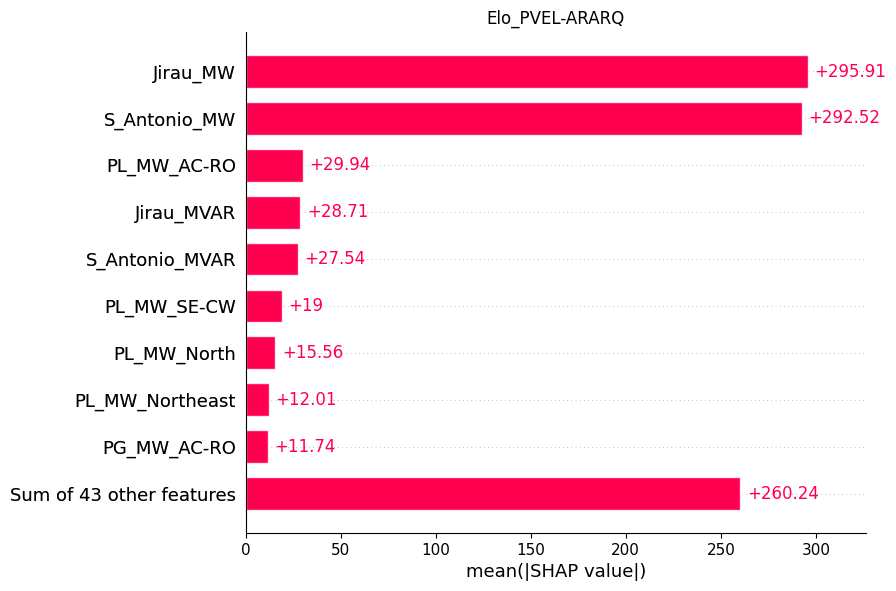

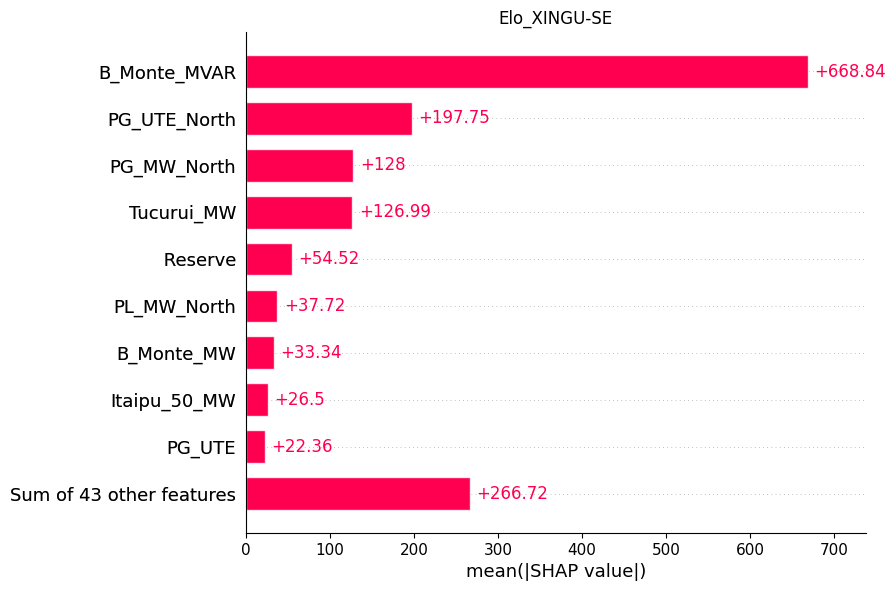

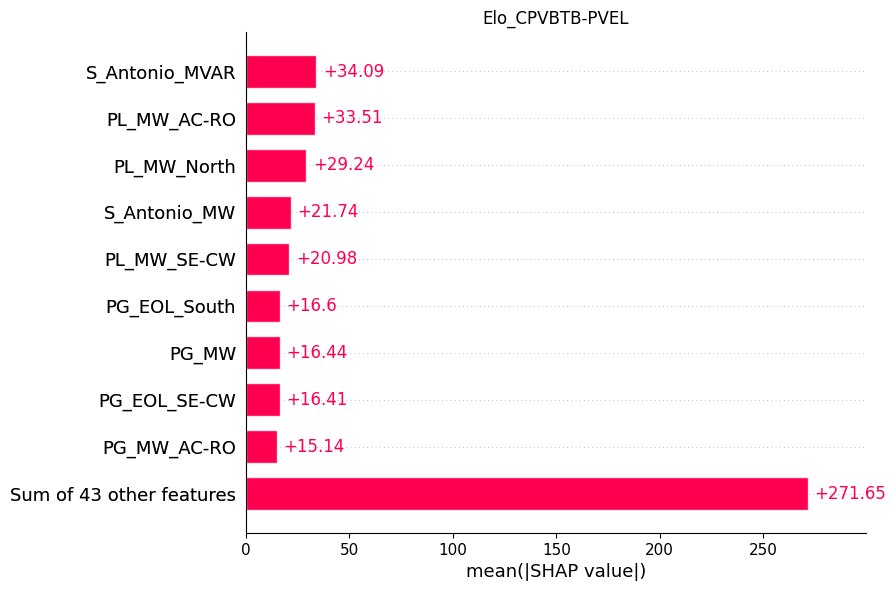

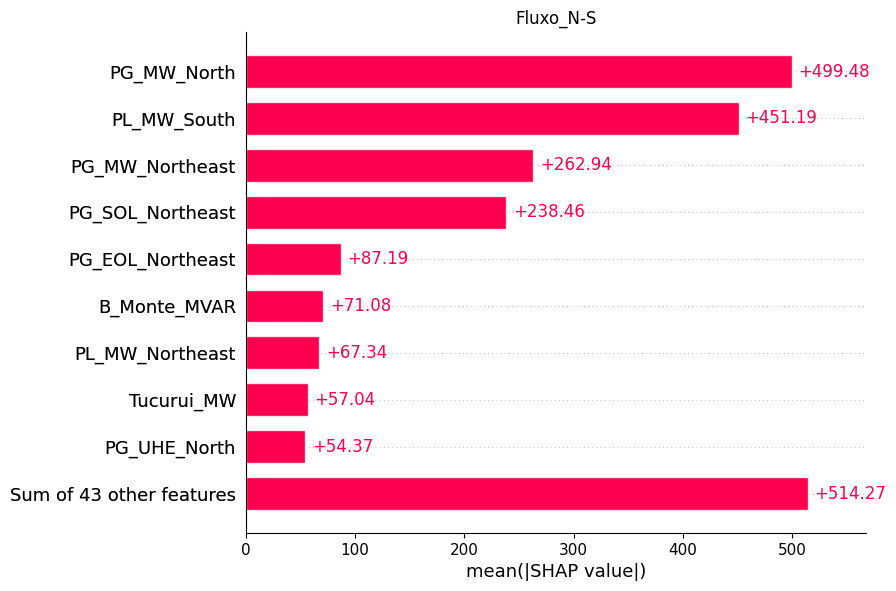

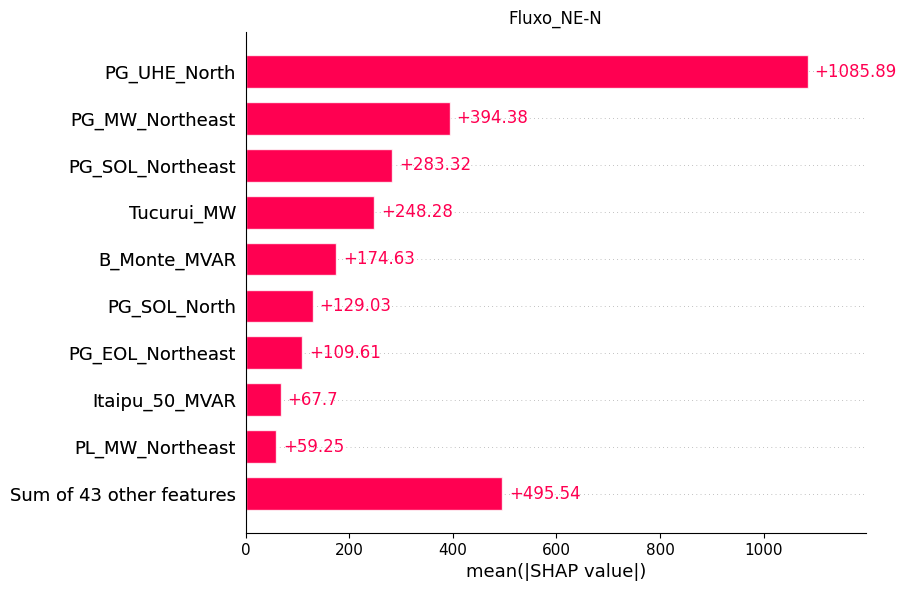

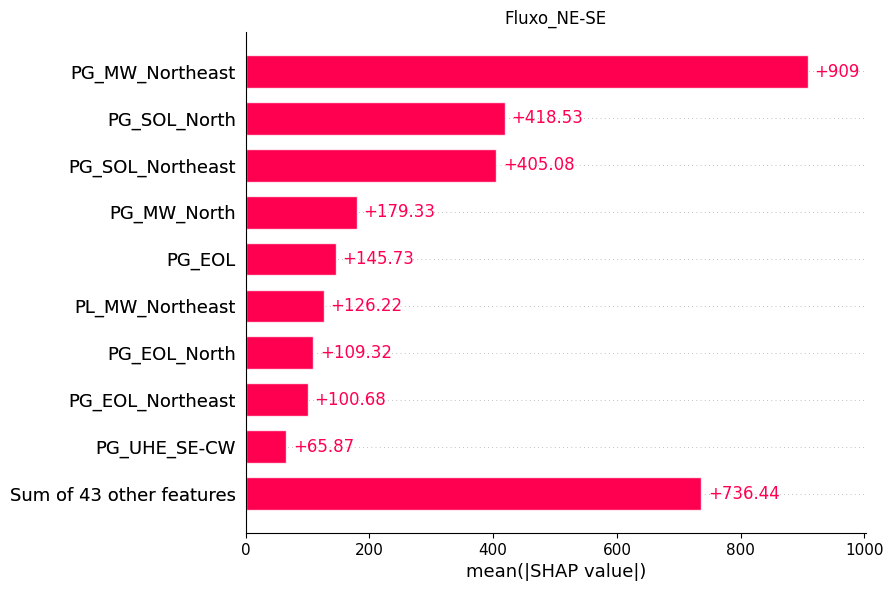

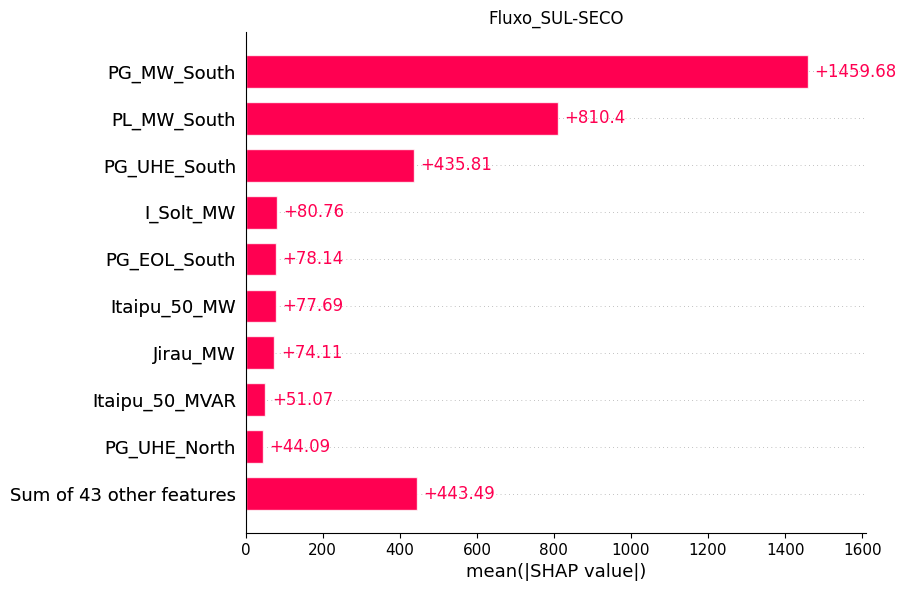

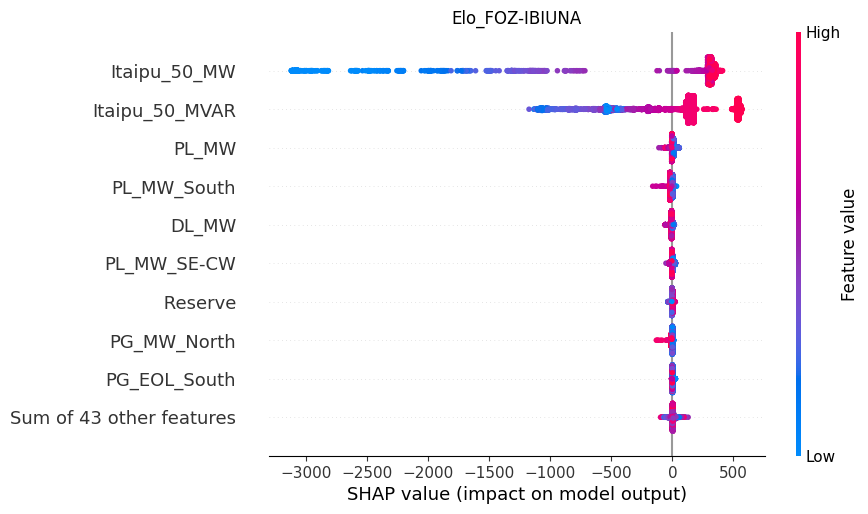

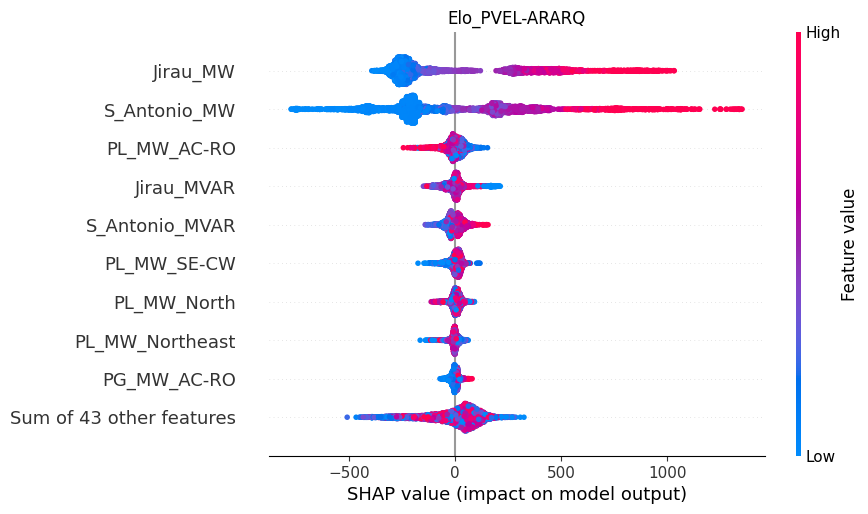

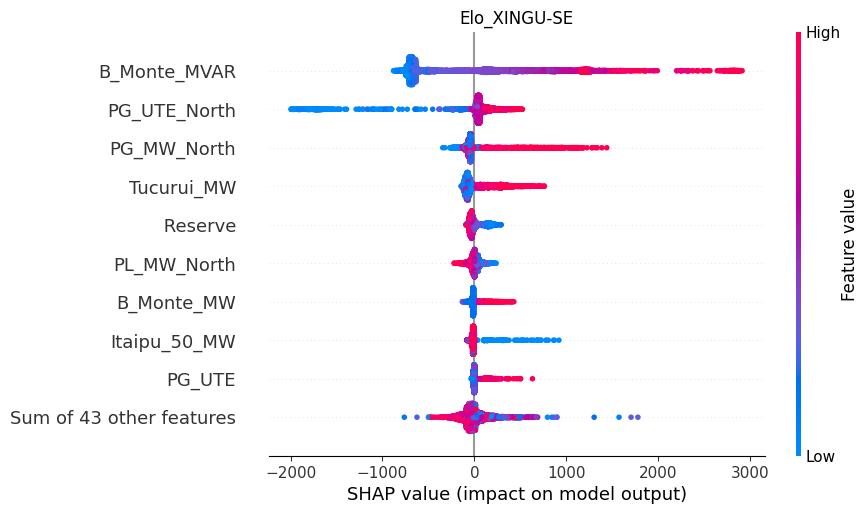

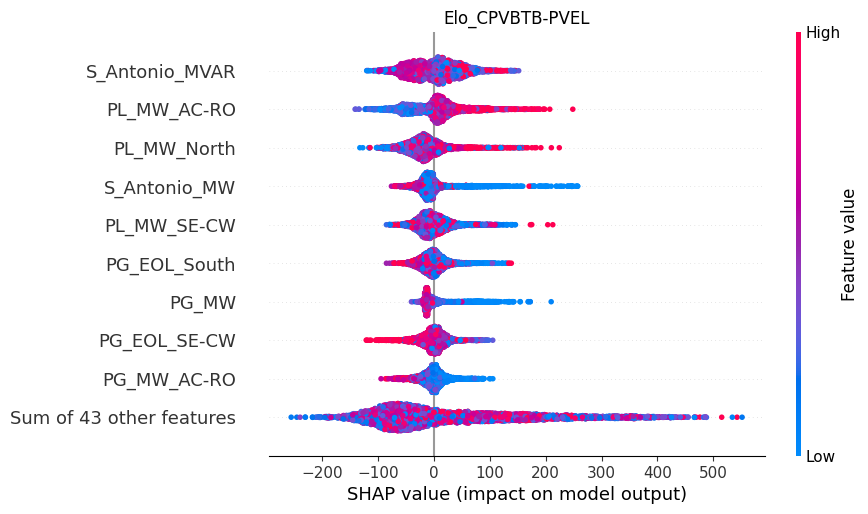

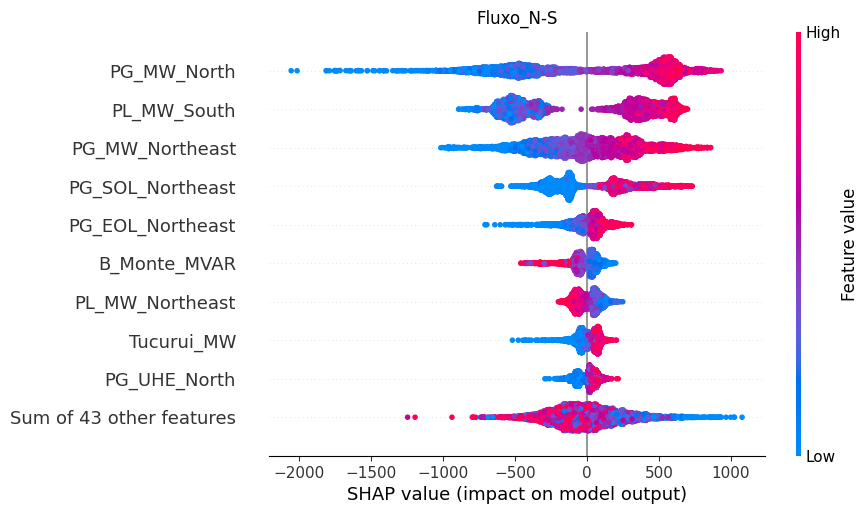

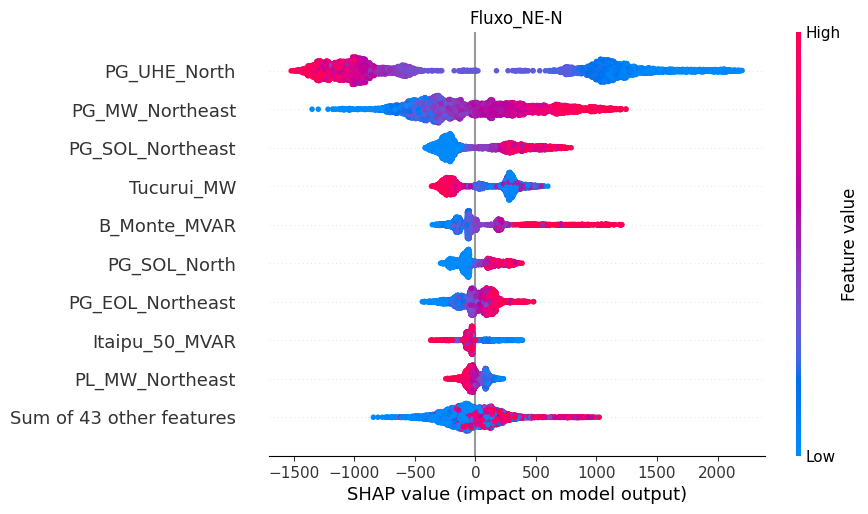

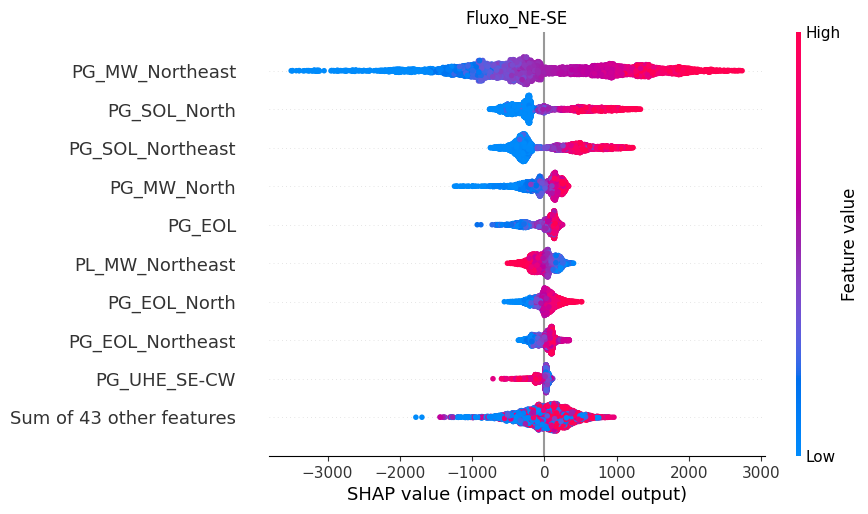

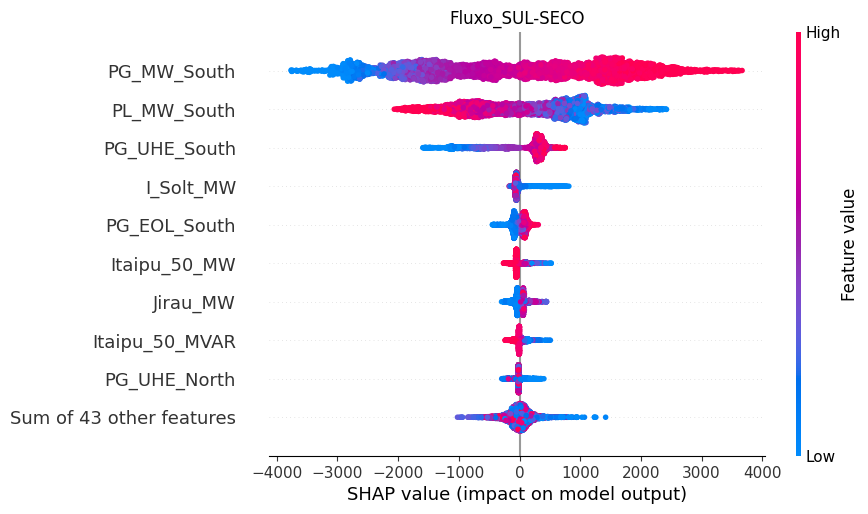

In [14]:
if shapValues:
    instance_index = 0
    #Mean SHAP
    for i in range(shapeshap_2[2]):
        plt.title(f'{Y.columns[i]}')
        shap.plots.bar(shap_values_2[:,:, i],max_display=10) #Features that have made large positive/negative contributions will have a large mean SHAP value.
    # Beeswarm plot
    for i in range(shapeshap_2[2]):
        plt.title(f'{Y.columns[i]}')
        shap.plots.beeswarm(shap_values_2[:,:, i],max_display=10)
    

In [15]:
shap.plots.force(shap_values_2[:100,:, 0]) # PV LOWER

In [16]:
# insecure_indices = df_indice_grop[df_indice_grop['DPI_PO_final'] > 1].index
# shapvalues_insecure = shap_values_2[insecure_indices.values]
# shap.plots.force(shapvalues_insecure[:,:, 6]) # PV LOWER

In [17]:
# alarm_indices = df_indice_grop[df_indice_grop['DPI_PO_final'] <= 1].index
# shapvalues_alarm = shap_values_2[alarm_indices.values]
# shap.plots.force(shapvalues_alarm[:,:, 9]) # P

In [18]:
# shap.plots.waterfall(shapvalues_insecure[5,:, 9],max_display=10)